In [1]:
import argparse
import os, sys
import time
import datetime
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import dynamic_resnet

In [2]:
# Model Definition  
net = dynamic_resnet.ResNet34()

# Dummy input of the same size as CIFAR-10 images
data = torch.randn(3,3,32,32)
# Forward pass input through the model to get output
out = net(data)

# Check output shape
assert(out.detach().cpu().numpy().shape == (3,10))
print("Model's outputs are of the correct shape\n")

# # Check number of parameters
# print('Number of parameters of all conv/FC layers:')
# for name, p in net.named_parameters():
#     print(f'{name:20} {p.numel():10}')

total = sum(p.numel() for name, p in net.named_parameters())
print(f'Total Number of parameters: {total}')

Model's outputs are of the correct shape

Total Number of parameters: 21282122


In [3]:
import torchvision
import torchvision.transforms as transforms

transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2023, 0.1994, 0.2010)),
    transforms.RandomCrop(32,padding=4),
    transforms.RandomHorizontalFlip()
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2023, 0.1994, 0.2010))
])

In [4]:
# do NOT change these
from torchvision import datasets
from torch.utils.data import DataLoader

# a few arguments, do NOT change these
DATA_ROOT = "./data"
TRAIN_BATCH_SIZE = 128
VAL_BATCH_SIZE = 100

# construct dataset
train_set = datasets.CIFAR10(root=DATA_ROOT, train=True, transform=transform_train, download=True)
val_set = datasets.CIFAR10(root=DATA_ROOT, train=False, transform=transform_val, download=True)

# construct dataloader
train_loader = DataLoader(
    train_set, 
    batch_size=TRAIN_BATCH_SIZE,  # your code
    shuffle=True,     # your code
    num_workers=16
)
val_loader = DataLoader(
    val_set, 
    batch_size=VAL_BATCH_SIZE,  # your code
    shuffle=False,     # your code
    num_workers=16
)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device =='cuda':
    print("Run on GPU...")
else:
    print("Run on CPU...")

net = net.to(device)

Run on GPU...


In [8]:
import torch.nn as nn
import torch.optim as optim

# initial learning rate
INITIAL_LR = 0.05

# momentum for optimizer
MOMENTUM = 0.9

# L2 regularization strength
REG = 2e-4

# create loss function
criterion = nn.CrossEntropyLoss()

# Add optimizer
optimizer = optim.SGD(net.parameters(), lr=INITIAL_LR, momentum=MOMENTUM, weight_decay=REG)

In [9]:
# some hyperparameters
# total number of training epochs
EPOCHS = 20
DECAY_EPOCHS = 5
DECAY = 0.5

# the folder where the trained model is saved
CHECKPOINT_FOLDER = "./saved_model"

# start the training/validation process
best_val_acc = 0.9
current_learning_rate = INITIAL_LR

print("==> Training starts!")
print("="*50)

# lists for plotting loss and accuracy
epoch_list = []
train_loss_list = []
train_acc_list = []
valid_loss_list = []
valid_acc_list = []

for i in range(0, EPOCHS):
    epoch_list.append(i+1)
    # handle the learning rate scheduler.
    if i % DECAY_EPOCHS == 0 and i != 0:
        current_learning_rate = current_learning_rate * DECAY
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_learning_rate
        print("Current learning rate has decayed to %f" %current_learning_rate)
    
    # switch to train mode
    net.train()
    
    print("Epoch %d:" %i)
    # this help you compute the training accuracy
    total_examples = 0
    correct_examples = 0

    train_loss = 0 # track training loss if you want
    
    # Train the model for 1 epoch.
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # copy inputs to device
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        # compute the output and loss
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        train_loss += loss
        
        # zero the gradient
        optimizer.zero_grad()
        
        # backpropagation
        loss.backward()
        
        # apply gradient and update the weights
        optimizer.step()
        
        # count the number of correctly predicted samples in the current batch
        _, predicted = torch.max(outputs.data, 1)
        total_examples += targets.size(0)
        correct_examples += (predicted==targets).sum().item()
                
    avg_loss = train_loss.detach().cpu().numpy() / len(train_loader)
    avg_acc = correct_examples / total_examples
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))
    train_loss_list.append(avg_loss)
    train_acc_list.append(avg_acc)

    # Validate on the validation dataset
    # switch to eval mode
    net.eval()

    # this help you compute the validation accuracy
    total_examples = 0
    correct_examples = 0
    
    val_loss = 0 # again, track the validation loss if you want

    # disable gradient during validation, which can save GPU memory
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            # copy inputs to device
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            # compute the output and loss
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss
            
            # count the number of correctly predicted samples in the current batch
            _, predicted = torch.max(outputs.data, 1)
            total_examples += targets.size(0)
            correct_examples += (predicted==targets).sum().item()

    avg_loss = val_loss.detach().cpu().numpy() / len(val_loader)
    avg_acc = correct_examples / total_examples
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))
    valid_loss_list.append(avg_loss)
    valid_acc_list.append(avg_acc)
    
    # save the model checkpoint
    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        if not os.path.exists(CHECKPOINT_FOLDER):
            os.makedirs(CHECKPOINT_FOLDER)
        print("Saving ...")
        state = {'state_dict': net.state_dict(),
                 'epoch': i,
                 'lr': current_learning_rate}
        torch.save(state, os.path.join(CHECKPOINT_FOLDER, 'resnet34.pth'))
        
    print('')

print("="*50)
print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")

==> Training starts!
Epoch 0:
Training loss: 0.3935, Training accuracy: 0.8629
Validation loss: 0.4740, Validation accuracy: 0.8463

Epoch 1:
Training loss: 0.3403, Training accuracy: 0.8812
Validation loss: 0.4201, Validation accuracy: 0.8623

Epoch 2:
Training loss: 0.3040, Training accuracy: 0.8935
Validation loss: 0.4507, Validation accuracy: 0.8537

Epoch 3:
Training loss: 0.2821, Training accuracy: 0.9015
Validation loss: 0.4343, Validation accuracy: 0.8603

Epoch 4:
Training loss: 0.2583, Training accuracy: 0.9100
Validation loss: 0.4357, Validation accuracy: 0.8564

Current learning rate has decayed to 0.025000
Epoch 5:
Training loss: 0.1744, Training accuracy: 0.9396
Validation loss: 0.3407, Validation accuracy: 0.8916

Epoch 6:
Training loss: 0.1481, Training accuracy: 0.9477
Validation loss: 0.3576, Validation accuracy: 0.8863

Epoch 7:
Training loss: 0.1424, Training accuracy: 0.9487
Validation loss: 0.3145, Validation accuracy: 0.9022
Saving ...

Epoch 8:
Training loss: 0.

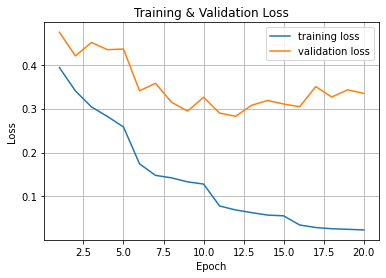

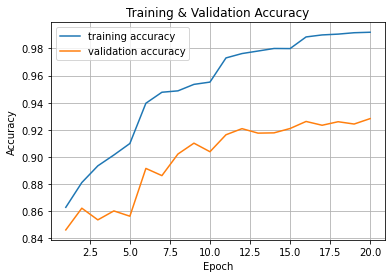

In [10]:
# plot training and validation loss/accuracy
plt.plot(epoch_list, train_loss_list, label='training loss')
plt.plot(epoch_list, valid_loss_list, label='validation loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid()
plt.show()

plt.plot(epoch_list, train_acc_list, label='training accuracy')
plt.plot(epoch_list, valid_acc_list, label='validation accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.grid()
plt.show()

In [11]:
def test_model(net, loader, device):
    # switch to eval mode
    net.eval()

    # this help you compute the validation accuracy
    total_examples = 0
    correct_examples = 0
    
    val_loss = 0 # again, track the validation loss if you want

    # disable gradient during validation, which can save GPU memory
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(loader):
            # copy inputs to device
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            # compute the output and loss
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss
            
            # count the number of correctly predicted samples in the current batch
            _, predicted = torch.max(outputs.data, 1)
            total_examples += targets.size(0)
            correct_examples += (predicted==targets).sum().item()
    avg_loss = val_loss.detach().cpu().numpy() / len(val_loader)
    avg_acc = correct_examples / total_examples
    return avg_loss, avg_acc

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device =='cuda':
    print("Run on GPU...")
else:
    print("Run on CPU...")

net = net.to(device)
net.load_state_dict(torch.load("./saved_model/resnet34.pth")['state_dict'])
avg_loss, avg_acc = test_model(net, val_loader, device)
print("TestLoss: {:.4f}; TestAcc: {:.4f}".format(avg_loss, avg_acc))

Run on GPU...
TestLoss: 0.3347; TestAcc: 0.9283


In [13]:
def test_model_policy(net, loader, device,policy):
    # switch to eval mode
    net.eval()

    # this help you compute the validation accuracy
    total_examples = 0
    correct_examples = 0
    
    val_loss = 0 # again, track the validation loss if you want

    # disable gradient during validation, which can save GPU memory
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(loader):
            # copy inputs to device
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            # compute the output and loss
            outputs = net(inputs,policy.to(device))
            loss = criterion(outputs, targets)
            val_loss += loss
            
            # count the number of correctly predicted samples in the current batch
            _, predicted = torch.max(outputs.data, 1)
            total_examples += targets.size(0)
            correct_examples += (predicted==targets).sum().item()
    avg_loss = val_loss.detach().cpu().numpy() / len(val_loader)
    avg_acc = correct_examples / total_examples
    return avg_loss, avg_acc

In [21]:
avg_loss, avg_acc = test_model_policy(net, val_loader, device,torch.tensor([1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0]))
print("TestLoss: {:.4f}; TestAcc: {:.4f}".format(avg_loss, avg_acc))

TestLoss: 0.3999; TestAcc: 0.8932


In [17]:
print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): Bat

In [66]:
# Drop layer
net.layer3[0] = net.layer3[0].shortcut
net.layer4[0] = net.layer4[0].shortcut
# net.layer2[0] = nn.Sequential()
# net.layer3[2] = nn.Sequential()
print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [67]:
avg_loss, avg_acc = test_model(net, val_loader, device)
print("TestLoss: {:.4f}; TestAcc: {:.4f}".format(avg_loss, avg_acc))

TestLoss: 3.2134; TestAcc: 0.1713
